In [103]:
import numpy as np
import kagglehub
import scipy.io
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [104]:
# Download latest version
path = kagglehub.dataset_download("dkrivosic/leeds-sports-pose-lsp")
print("Path to dataset files:", path)

Path to dataset files: /Users/lionelseoanerollan/.cache/kagglehub/datasets/dkrivosic/leeds-sports-pose-lsp/versions/1


In [105]:
# Load the .mat annotation file
annotations = scipy.io.loadmat(f'{path}/joints.mat')

# Extract keypoints from 'joints'
joints = annotations['joints']

# Image Folder
image_folder = f'{path}/images/'

# Joints vector [3[14[2000]]]
num_images = len(joints[0][0])

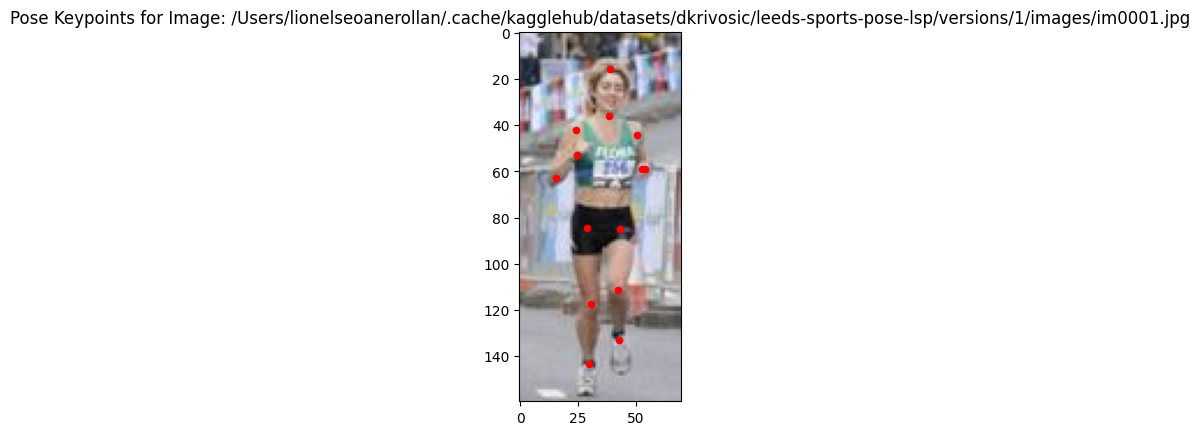

In [106]:
# Example: Load the first image and its corresponding keypoints
index = 0

# Construct the image path based on the naming convention
image_path = os.path.join(image_folder, f'im{index + 1:04d}.jpg')  # 'im0001.jpg', 'im0002.jpg', etc.

# Load the image using OpenCV
img = cv2.imread(image_path)
original_height, original_width = img.shape[:2]

# Get the keypoints for the current image
keypoints = joints[:, :, index]  # Access the keypoints for the image at index

# Plot the image with keypoints
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display in matplotlib

# Loop over each joint and plot its (x, y) coordinates
for i in range(14):  # Loop over the 14 joints
    x = keypoints[0, i] 
    y = keypoints[1, i] 
    plt.scatter(x, y, color='red', s=20)  # Plot the keypoints as red dots

plt.title(f'Pose Keypoints for Image: {image_path}')
plt.show()

In [131]:
target_size = 100

# Indices for the images
indices = np.arange(num_images)

# Split the data into train (80%) and test (20%)
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(train_indices)}")
print(f"Number of test samples: {len(test_indices)}")

# Function to normalize keypoints
def normalize_keypoints(keypoints, image_width, image_height):
    normalized_keypoints = keypoints.copy()
    normalized_keypoints[:, 0] /= image_width  # Normalize x by image width
    normalized_keypoints[:, 1] /= image_height  # Normalize y by image height
    return normalized_keypoints

# Function to resize image and adjust keypoints
def resize_and_pad_image(image, keypoints, target_size):

    original_height, original_width = image.shape[:2]

    # Determine the scaling factor
    scale = target_size / max(original_width, original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    # Calculate padding to make the image square
    pad_left = (target_size - new_width) // 2
    pad_right = target_size - new_width - pad_left
    pad_top = (target_size - new_height) // 2
    pad_bottom = target_size - new_height - pad_top

    # Pad the image
    padded_image = cv2.copyMakeBorder(
        resized_image, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
    )

    # Adjust keypoints for resizing and padding
    adjusted_keypoints = keypoints.copy()
    adjusted_keypoints[:, 0] = adjusted_keypoints[:, 0] * scale + pad_left
    adjusted_keypoints[:, 1] = adjusted_keypoints[:, 1] * scale + pad_top

    return padded_image, adjusted_keypoints, (pad_left, pad_top, pad_right, pad_bottom)

# Function to load images given a list of indices
def load_images(indices, image_folder, target_size=150):
    images = []
    normalized_keypoints_list = []
    
    for idx in indices:
        # Construct image file path
        image_path = os.path.join(image_folder, f'im{idx + 1:04d}.jpg')  # Example: 'im0001.jpg'
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        keypoints = joints[:2, :, idx].T  # Shape: (14, 2)
        
        if image is not None:

            # Resize, pad, and adjust the keypoints
            processed_image, adjusted_keypoints, _ = resize_and_pad_image(image, keypoints, target_size)

            # Normalize the keypoints to the range [0, 1]
            normalized_keypoints = normalize_keypoints(adjusted_keypoints, target_size, target_size)

            # Convert BGR to RGB (OpenCV loads in BGR by default)
            processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

            # Normalize the image pixel values to [0, 1]
            processed_image = processed_image / 255.0
            
            images.append(processed_image)
            normalized_keypoints_list.append(normalized_keypoints)
        else:
            print(f"Warning: Image {image_path} could not be loaded.")
    
    # Convert the list of images into a numpy array (now they will all have the same shape)
    return np.array(images), np.array(normalized_keypoints_list)

# Load images and prepare data
train_images, train_keypoints = load_images(train_indices, image_folder, target_size)
test_images, test_keypoints = load_images(test_indices, image_folder, target_size)

print(train_images.shape)
print(train_keypoints.shape)

Number of training samples: 1600
Number of test samples: 400
(1600, 100, 100, 3)
(1600, 14, 2)


In [132]:
# Reshaping images
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
print(train_images.shape)

# Reshaping keypoints
train_keypoints = torch.tensor(train_keypoints, dtype=torch.float32)
test_keypoints = torch.tensor(test_keypoints, dtype=torch.float32)
train_keypoints = train_keypoints.reshape(-1, 14, 2)  # Shape: (num_samples, 14, 2)
test_keypoints = test_keypoints.reshape(-1, 14, 2)  # Shape: (num_samples, 14, 2)

print(train_keypoints.shape)

torch.Size([1600, 3, 100, 100])
torch.Size([1600, 14, 2])


In [133]:
batch_size = 32
train_dataset = TensorDataset(train_images, train_keypoints)
test_dataset = TensorDataset(test_images, test_keypoints)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [136]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted for 256x6x6 after max pooling
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 14 * 2)  # Predict 14 keypoints (x, y)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        x = x.view(-1, 14, 2)  # Reshape to (batch_size, 14, 2)
        
        return x


In [137]:
# Initialize the model
model = KeypointCNN()

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU if available
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print training progress
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), "keypoint_cnn.pth")

Epoch [1/5], Loss: 1.110399607270956
Epoch [2/5], Loss: 0.08681994147598743
Epoch [3/5], Loss: 0.0756660271435976
Epoch [4/5], Loss: 0.07500976853072644
Epoch [5/5], Loss: 0.06941628895699978


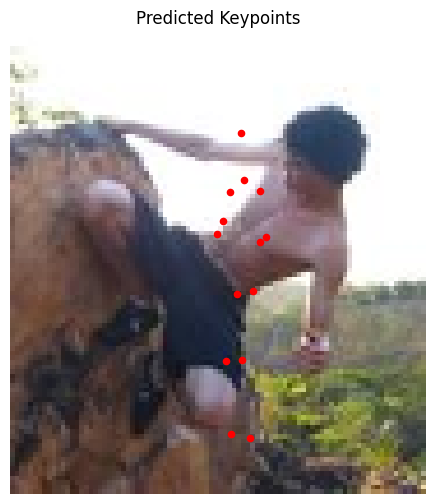

In [156]:
def denormalize_image(processed_image, padding):
    """
    Denormalize the image by scaling pixel values back to [0, 255] and adjusting padding.
    """
    # Reverse the normalization (scale back to [0, 255])
    denormalized_image = processed_image * 255.0
    
    # Undo padding (assuming padding order is [pad_left, pad_top, pad_right, pad_bottom])
    pad_left, pad_top, pad_right, pad_bottom = padding
    
    # Ensure we don't go out of bounds
    height, width = denormalized_image.shape[:2]
    
    # Calculate crop boundaries, ensuring no negative or out-of-bounds indices
    crop_top = max(pad_top, 0)
    crop_bottom = max(height - pad_bottom, 0)
    crop_left = max(pad_left, 0)
    crop_right = max(width - pad_right, 0)
    
    # Crop the image and avoid empty slices
    denormalized_image = denormalized_image[crop_top:crop_bottom, crop_left:crop_right]
    
    # Ensure the image is in [0, 255] range for visualization
    denormalized_image = np.clip(denormalized_image, 0, 255).astype(np.uint8)
    
    return denormalized_image

def preprocess_image(image, target_size=150):
    """
    Resize, pad, and normalize an input image for prediction.
    """
    # Resize and pad the image to the target size
    processed_image, _, padding = resize_and_pad_image(image, np.zeros((14, 2)), target_size)
    
    # Convert BGR to RGB (OpenCV loads in BGR by default)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    
    # Normalize pixel values to [0, 1]
    processed_image = processed_image / 255.0
    
    return processed_image, padding

def predict_keypoints(model, image, target_size=150):
    """
    Predict normalized keypoints for a given image.
    """
    # Preprocess the image and get padding
    processed_image, padding = preprocess_image(image, target_size)
    
    # Convert image to tensor and prepare for prediction
    input_tensor = torch.tensor(processed_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    # Move the tensor to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        input_tensor = input_tensor.cuda()

    # Make predictions
    with torch.no_grad():
        output = model(input_tensor)  # Output shape: (1, 14, 2)

    # Convert output to numpy array
    predicted_keypoints = output.cpu().numpy().squeeze()  # Shape: (14, 2)
    
    # Denormalize the keypoints to the original image dimensions
    denormalized_keypoints = denormalize_keypoints(predicted_keypoints, processed_image.shape[1], processed_image.shape[0])

    # Adjust the keypoints to remove the padding
    pad_left, pad_top, pad_right, pad_bottom = padding
    denormalized_keypoints[:, 0] -= pad_left  # Remove left padding
    denormalized_keypoints[:, 1] -= pad_top   # Remove top padding

    # Denormalize the image to show the original image
    denormalized_image = denormalize_image(processed_image, padding)

    return denormalized_image, denormalized_keypoints

def visualize_keypoints(image, keypoints):
    """
    Display an image with keypoints overlaid.
    
    Args:
        image (np.ndarray): The input image (RGB format, shape: HxWx3).
        keypoints (np.ndarray): Array of shape (14, 2) containing (x, y) keypoints.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)  # Display the image
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=20)  # Overlay keypoints
    plt.title("Predicted Keypoints")
    plt.axis('off')  # Hide axes
    plt.show()

# Load an example image
test_image_index = 2
image_path = os.path.join(image_folder, f'im{test_image_index + 1:04d}.jpg')  # 'im0001.jpg', 'im0002.jpg', etc.
image = cv2.imread(image_path)
original_height, original_width = image.shape[:2]

# Predict keypoints and get denormalized image
denormalized_image, denormalized_keypoints = predict_keypoints(model, image, target_size=100)

# Visualize the image with keypoints
visualize_keypoints(denormalized_image, denormalized_keypoints)

